In [11]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from implicit import als
from implicit.evaluation import mean_average_precision_at_k
import os


In [12]:
os.environ["MKL_NUM_THREADS"] = "1"

In [13]:

# Membaca dataset
train_df = pd.read_csv('D:/SEM 7 TA/Sistem Rekomendasi/proyek/proyek sisrek/train.csv')


In [14]:

# Menambahkan kolom interaction dengan nilai 1 (karena interaksi hanya 1)
train_df['interaction'] = 1


In [15]:
# Membuat mapping untuk user_id dan item_id
user_mapping = {user: idx for idx, user in enumerate(train_df['user_id'].unique())}
item_mapping = {item: idx for idx, item in enumerate(train_df['item_id'].unique())}


In [16]:
# Mengganti user_id dan item_id dengan indeks
train_df['user_idx'] = train_df['user_id'].map(user_mapping)
train_df['item_idx'] = train_df['item_id'].map(item_mapping)


In [17]:

# Membuat sparse matrix (user-item matrix)
sparse_matrix = csr_matrix((train_df['interaction'], (train_df['user_idx'], train_df['item_idx'])))


In [18]:
# Membangun model ALS
model = als.AlternatingLeastSquares(factors=50, regularization=0.1, iterations=30, random_state=42)

In [19]:

# Melatih model ALS
model.fit(sparse_matrix)


  0%|          | 0/30 [00:00<?, ?it/s]

In [20]:
def get_recommendations(user_id, model, sparse_matrix, num_recommendations=10):
    user_idx = user_id
    results = model.recommend(user_idx, sparse_matrix[user_idx], N=num_recommendations)

    if isinstance(results, tuple) and len(results) == 2:
        item_ids, scores = results
        recommended_items = list(item_ids)
    else:
        recommended_items = [item for item, score in results]

    return recommended_items


In [21]:
print(type(get_recommendations))
print(get_recommendations)


<class 'function'>
<function get_recommendations at 0x000002D21227DEE0>


In [22]:
user_id = 1
recommended_items = get_recommendations(user_id, model, sparse_matrix, num_recommendations=10)
print(f"Rekomendasi untuk pengguna {user_id}: {recommended_items}")

Rekomendasi untuk pengguna 1: [366, 351, 18, 154, 538, 1069, 131, 531, 2080, 138]


In [31]:
from sklearn.model_selection import train_test_split
from scipy.sparse import csr_matrix

# Pisahkan sebagian interaksi tiap user untuk test
def train_test_split_per_user(df, test_ratio=0.2):
    test_list = []
    train_list = []
    for user_id, group in df.groupby('user_idx'):
        if len(group) > 1:
            test_size = max(1, int(len(group) * test_ratio))
            test_sample = group.sample(test_size, random_state=42)
            train_sample = group.drop(test_sample.index)
            test_list.append(test_sample)
            train_list.append(train_sample)
        else:
            train_list.append(group)
    return pd.concat(train_list), pd.concat(test_list)

train_df_split, test_df_split = train_test_split_per_user(train_df)

# Buat sparse matrix baru
train_matrix = csr_matrix((train_df_split['interaction'], (train_df_split['user_idx'], train_df_split['item_idx'])))
test_matrix = csr_matrix((test_df_split['interaction'], (test_df_split['user_idx'], test_df_split['item_idx'])))

# Latih ulang model
model.fit(train_matrix)

# Hitung MAP
map_score = mean_average_precision(model, test_df_split, train_matrix, k=10, sample_users=100)
print(f"Mean Average Precision (MAP@10): {map_score:.4f}")


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 187.23it/s]

Mean Average Precision (MAP@10): 0.0111


In [32]:
user = np.random.choice(train_df['user_idx'].unique())
rec_items, scores = model.recommend(user, sparse_matrix[user], N=10)
print("User:", user)
print("Recommended items:", rec_items)
print("Actual items:", train_df[train_df['user_idx']==user]['item_idx'].tolist())


User: 1019
Recommended items: [ 1892   531   669   191  4711 15822 20807  4324   703   845]
Actual items: [8406, 19093, 19094, 19095, 19096, 19097, 7029, 19098, 19099, 19100, 19101, 19102, 19103, 19104, 19105, 19106, 19107, 19108, 9258, 19109, 19110, 19111, 19112, 11934]


## SETELAH TUNNING

  0%|          | 0/150 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  1%|          | 1/150 [00:06<17:14,  6.94s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

  1%|▏         | 2/150 [00:18<24:18,  9.85s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

  2%|▏         | 3/150 [00:35<31:34, 12.89s/it]

  0%|          | 0/80 [00:00<?, ?it/s]

  3%|▎         | 4/150 [00:59<42:20, 17.40s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  3%|▎         | 5/150 [01:28<51:43, 21.40s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  4%|▍         | 6/150 [01:35<39:39, 16.52s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

  5%|▍         | 7/150 [01:46<35:27, 14.88s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

  5%|▌         | 8/150 [02:02<36:09, 15.28s/it]

  0%|          | 0/80 [00:00<?, ?it/s]

  6%|▌         | 9/150 [02:24<40:25, 17.20s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  7%|▋         | 10/150 [02:49<46:15, 19.82s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

  7%|▋         | 11/150 [02:56<36:25, 15.72s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

  8%|▊         | 12/150 [03:07<33:05, 14.39s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

  9%|▊         | 13/150 [03:23<33:55, 14.85s/it]

  0%|          | 0/80 [00:00<?, ?it/s]

  9%|▉         | 14/150 [03:45<38:24, 16.95s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 10%|█         | 15/150 [04:11<44:31, 19.79s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 11%|█         | 16/150 [04:18<35:09, 15.74s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 11%|█▏        | 17/150 [04:29<32:01, 14.44s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

 12%|█▏        | 18/150 [04:45<33:00, 15.01s/it]

  0%|          | 0/80 [00:00<?, ?it/s]

 13%|█▎        | 19/150 [05:05<36:00, 16.49s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 13%|█▎        | 20/150 [05:30<41:10, 19.00s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 14%|█▍        | 21/150 [05:37<32:51, 15.28s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 15%|█▍        | 22/150 [05:50<31:27, 14.75s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

 15%|█▌        | 23/150 [06:09<33:58, 16.05s/it]

  0%|          | 0/80 [00:00<?, ?it/s]

 16%|█▌        | 24/150 [06:34<39:18, 18.72s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 17%|█▋        | 25/150 [07:06<47:20, 22.72s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 17%|█▋        | 26/150 [07:30<47:20, 22.91s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 18%|█▊        | 27/150 [08:11<58:23, 28.49s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

 19%|█▊        | 28/150 [09:13<1:18:14, 38.48s/it]

  0%|          | 0/80 [00:00<?, ?it/s]

 19%|█▉        | 29/150 [10:40<1:47:03, 53.09s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 30/150 [12:19<2:13:43, 66.86s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 21%|██        | 31/150 [12:44<1:47:44, 54.33s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 21%|██▏       | 32/150 [13:33<1:43:39, 52.71s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

 22%|██▏       | 33/150 [14:46<1:54:19, 58.63s/it]

  0%|          | 0/80 [00:00<?, ?it/s]

 23%|██▎       | 34/150 [16:05<2:05:25, 64.87s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 23%|██▎       | 35/150 [17:42<2:22:46, 74.49s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 24%|██▍       | 36/150 [18:02<1:50:32, 58.18s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 25%|██▍       | 37/150 [18:41<1:38:41, 52.40s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

 25%|██▌       | 38/150 [19:42<1:42:25, 54.87s/it]

  0%|          | 0/80 [00:00<?, ?it/s]

 26%|██▌       | 39/150 [21:01<1:55:12, 62.28s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 27%|██▋       | 40/150 [22:41<2:15:03, 73.67s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 27%|██▋       | 41/150 [23:06<1:47:11, 59.00s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 28%|██▊       | 42/150 [23:48<1:36:38, 53.69s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

 29%|██▊       | 43/150 [24:48<1:39:21, 55.72s/it]

  0%|          | 0/80 [00:00<?, ?it/s]

 29%|██▉       | 44/150 [26:02<1:48:13, 61.26s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 30%|███       | 45/150 [27:31<2:01:43, 69.55s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 31%|███       | 46/150 [27:52<1:35:13, 54.94s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 31%|███▏      | 47/150 [28:29<1:24:52, 49.44s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

 32%|███▏      | 48/150 [29:22<1:26:14, 50.73s/it]

  0%|          | 0/80 [00:00<?, ?it/s]

 33%|███▎      | 49/150 [30:35<1:36:33, 57.36s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 33%|███▎      | 50/150 [32:00<1:49:11, 65.51s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 34%|███▍      | 51/150 [32:41<1:36:04, 58.22s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 35%|███▍      | 52/150 [33:55<1:42:50, 62.96s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

 35%|███▌      | 53/150 [35:44<2:04:00, 76.71s/it]

  0%|          | 0/80 [00:00<?, ?it/s]

 36%|███▌      | 54/150 [38:08<2:35:14, 97.02s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 37%|███▋      | 55/150 [40:56<3:07:24, 118.36s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 37%|███▋      | 56/150 [41:20<2:20:47, 89.87s/it] 

  0%|          | 0/40 [00:00<?, ?it/s]

 38%|███▊      | 57/150 [42:03<1:57:52, 76.05s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

 39%|███▊      | 58/150 [43:17<1:55:27, 75.30s/it]

  0%|          | 0/80 [00:00<?, ?it/s]

 39%|███▉      | 59/150 [45:09<2:10:47, 86.24s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 40%|████      | 60/150 [48:06<2:50:26, 113.63s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 41%|████      | 61/150 [48:44<2:14:45, 90.85s/it] 

  0%|          | 0/40 [00:00<?, ?it/s]

 41%|████▏     | 62/150 [49:56<2:05:06, 85.31s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

 42%|████▏     | 63/150 [51:43<2:12:48, 91.59s/it]

  0%|          | 0/80 [00:00<?, ?it/s]

 43%|████▎     | 64/150 [53:36<2:20:47, 98.23s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 43%|████▎     | 65/150 [55:53<2:35:26, 109.73s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 44%|████▍     | 66/150 [56:33<2:04:21, 88.83s/it] 

  0%|          | 0/40 [00:00<?, ?it/s]

 45%|████▍     | 67/150 [57:46<1:56:26, 84.17s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

 45%|████▌     | 68/150 [59:13<1:55:56, 84.84s/it]

  0%|          | 0/80 [00:00<?, ?it/s]

 46%|████▌     | 69/150 [1:00:41<1:56:08, 86.02s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 47%|████▋     | 70/150 [1:02:38<2:06:50, 95.13s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 47%|████▋     | 71/150 [1:03:05<1:38:29, 74.81s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 48%|████▊     | 72/150 [1:03:59<1:29:06, 68.55s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

 49%|████▊     | 73/150 [1:05:13<1:29:54, 70.06s/it]

  0%|          | 0/80 [00:00<?, ?it/s]

 49%|████▉     | 74/150 [1:06:52<1:39:57, 78.91s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 50%|█████     | 75/150 [1:08:49<1:52:46, 90.23s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 51%|█████     | 76/150 [1:09:29<1:32:36, 75.09s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 51%|█████▏    | 77/150 [1:10:48<1:32:43, 76.21s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

 52%|█████▏    | 78/150 [1:12:48<1:47:30, 89.59s/it]

  0%|          | 0/80 [00:00<?, ?it/s]

 53%|█████▎    | 79/150 [1:15:13<2:05:42, 106.23s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 53%|█████▎    | 80/150 [1:18:20<2:32:00, 130.29s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 54%|█████▍    | 81/150 [1:19:03<1:59:42, 104.10s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 55%|█████▍    | 82/150 [1:20:19<1:48:22, 95.62s/it] 

  0%|          | 0/60 [00:00<?, ?it/s]

 55%|█████▌    | 83/150 [1:22:16<1:54:10, 102.25s/it]

  0%|          | 0/80 [00:00<?, ?it/s]

 56%|█████▌    | 84/150 [1:25:05<2:14:22, 122.16s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 57%|█████▋    | 85/150 [1:28:47<2:44:39, 151.99s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 57%|█████▋    | 86/150 [1:29:32<2:08:01, 120.02s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 58%|█████▊    | 87/150 [1:30:54<1:54:08, 108.71s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

 59%|█████▊    | 88/150 [1:32:47<1:53:34, 109.91s/it]

  0%|          | 0/80 [00:00<?, ?it/s]

 59%|█████▉    | 89/150 [1:35:16<2:03:36, 121.58s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 60%|██████    | 90/150 [1:38:42<2:27:01, 147.02s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 61%|██████    | 91/150 [1:39:27<1:54:27, 116.40s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 61%|██████▏   | 92/150 [1:40:53<1:43:34, 107.15s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

 62%|██████▏   | 93/150 [1:42:46<1:43:27, 108.90s/it]

  0%|          | 0/80 [00:00<?, ?it/s]

 63%|██████▎   | 94/150 [1:45:33<1:57:59, 126.42s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 63%|██████▎   | 95/150 [1:48:40<2:12:34, 144.62s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 64%|██████▍   | 96/150 [1:49:45<1:48:36, 120.67s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 65%|██████▍   | 97/150 [1:51:57<1:49:44, 124.24s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

 65%|██████▌   | 98/150 [1:55:24<2:08:57, 148.81s/it]

  0%|          | 0/80 [00:00<?, ?it/s]

 66%|██████▌   | 99/150 [1:59:39<2:33:39, 180.77s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 67%|██████▋   | 100/150 [2:04:43<3:01:25, 217.72s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 67%|██████▋   | 101/150 [2:06:23<2:29:05, 182.56s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 68%|██████▊   | 102/150 [2:09:36<2:28:27, 185.58s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

 69%|██████▊   | 103/150 [2:14:16<2:47:35, 213.94s/it]

  0%|          | 0/80 [00:00<?, ?it/s]

 69%|██████▉   | 104/150 [2:20:10<3:16:17, 256.04s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 70%|███████   | 105/150 [2:27:49<3:57:33, 316.75s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 71%|███████   | 106/150 [2:29:31<3:05:09, 252.49s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 71%|███████▏  | 107/150 [2:32:56<2:50:45, 238.26s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

 72%|███████▏  | 108/150 [2:36:38<2:43:16, 233.26s/it]

  0%|          | 0/80 [00:00<?, ?it/s]

 73%|███████▎  | 109/150 [2:40:31<2:39:22, 233.23s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 73%|███████▎  | 110/150 [2:45:13<2:45:16, 247.92s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 74%|███████▍  | 111/150 [2:46:14<2:04:39, 191.77s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 75%|███████▍  | 112/150 [2:48:05<1:46:07, 167.57s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

 75%|███████▌  | 113/150 [2:50:47<1:42:20, 165.96s/it]

  0%|          | 0/80 [00:00<?, ?it/s]

 76%|███████▌  | 114/150 [2:54:30<1:49:49, 183.03s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 77%|███████▋  | 115/150 [2:59:20<2:05:29, 215.14s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 77%|███████▋  | 116/150 [3:00:19<1:35:19, 168.22s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 78%|███████▊  | 117/150 [4:02:57<11:24:44, 1244.99s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

 79%|███████▊  | 118/150 [4:07:50<8:31:46, 959.58s/it]  

  0%|          | 0/80 [00:00<?, ?it/s]

 79%|███████▉  | 119/150 [4:14:23<6:47:57, 789.58s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 80%|████████  | 120/150 [4:22:40<5:50:53, 701.77s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 81%|████████  | 121/150 [4:24:23<4:12:21, 522.11s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 81%|████████▏ | 122/150 [4:27:51<3:19:37, 427.78s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

 82%|████████▏ | 123/150 [4:32:50<2:55:10, 389.27s/it]

  0%|          | 0/80 [00:00<?, ?it/s]

 83%|████████▎ | 124/150 [4:39:16<2:48:14, 388.24s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 83%|████████▎ | 125/150 [4:47:32<2:55:14, 420.58s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 84%|████████▍ | 126/150 [4:50:01<2:15:40, 339.19s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 85%|████████▍ | 127/150 [4:54:18<2:00:36, 314.63s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

 85%|████████▌ | 128/150 [4:58:39<1:49:21, 298.27s/it]

  0%|          | 0/80 [00:00<?, ?it/s]

 86%|████████▌ | 129/150 [5:04:25<1:49:27, 312.73s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 87%|████████▋ | 130/150 [5:11:17<1:54:09, 342.47s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 87%|████████▋ | 131/150 [5:12:52<1:24:57, 268.30s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 88%|████████▊ | 132/150 [5:15:54<1:12:44, 242.49s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

 89%|████████▊ | 133/150 [5:20:26<1:11:09, 251.15s/it]

  0%|          | 0/80 [00:00<?, ?it/s]

 89%|████████▉ | 134/150 [5:26:20<1:15:15, 282.20s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 90%|█████████ | 135/150 [5:33:38<1:22:13, 328.90s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 91%|█████████ | 136/150 [5:35:12<1:00:15, 258.22s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 91%|█████████▏| 137/150 [5:38:04<50:20, 232.35s/it]  

  0%|          | 0/60 [00:00<?, ?it/s]

 92%|█████████▏| 138/150 [5:45:21<58:46, 293.85s/it]

  0%|          | 0/80 [00:00<?, ?it/s]

 93%|█████████▎| 139/150 [5:56:04<1:13:05, 398.65s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 93%|█████████▎| 140/150 [6:08:32<1:23:54, 503.49s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 94%|█████████▍| 141/150 [6:10:53<59:12, 394.78s/it]  

  0%|          | 0/40 [00:00<?, ?it/s]

 95%|█████████▍| 142/150 [6:15:09<47:05, 353.18s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

 95%|█████████▌| 143/150 [6:19:48<38:35, 330.81s/it]

  0%|          | 0/80 [00:00<?, ?it/s]

 96%|█████████▌| 144/150 [6:25:57<34:13, 342.20s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

 97%|█████████▋| 145/150 [6:33:37<31:27, 377.47s/it]

  0%|          | 0/20 [00:00<?, ?it/s]

 97%|█████████▋| 146/150 [6:35:20<19:40, 295.16s/it]

  0%|          | 0/40 [00:00<?, ?it/s]

 98%|█████████▊| 147/150 [6:38:20<13:02, 260.72s/it]

  0%|          | 0/60 [00:00<?, ?it/s]

 99%|█████████▊| 148/150 [6:42:54<08:49, 264.83s/it]

  0%|          | 0/80 [00:00<?, ?it/s]

 99%|█████████▉| 149/150 [6:48:56<04:53, 293.98s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 150/150 [6:56:27<00:00, 166.58s/it]


=== Hasil Tuning Lanjutan ===
     factors  regularization  iterations    MAP@10
72       150           0.200          60  0.006750
52       150           0.001          60  0.006125
78       200           0.001          80  0.005750
68       150           0.100          80  0.005500
92       200           0.100          60  0.005500
88       200           0.050          80  0.004875
65       150           0.100          20  0.004583
90       200           0.100          20  0.004500
41       100           0.100          40  0.004458
29       100           0.001         100  0.004458
144      300           0.100         100  0.004000
142      300           0.100          60  0.004000
35       100           0.050          20  0.003875
100      250           0.001          20  0.003750
42       100           0.100          60  0.003750


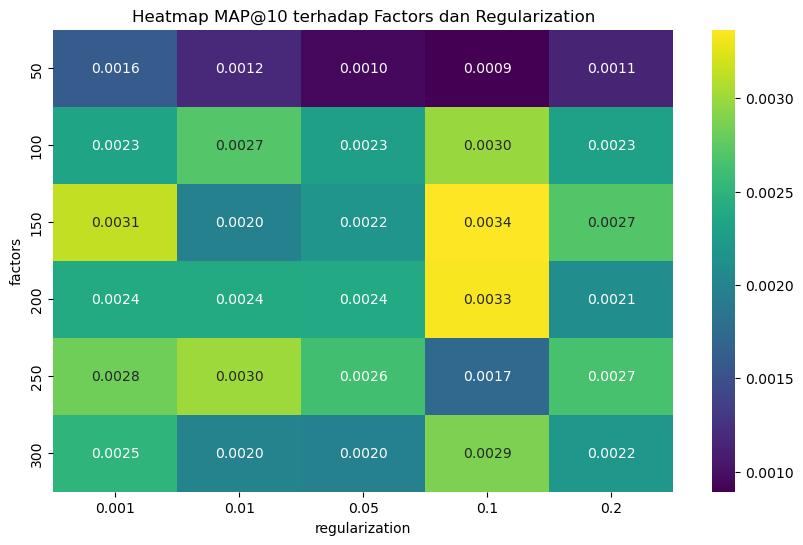

In [34]:
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from implicit.als import AlternatingLeastSquares

def mean_average_precision(model, train_df, sparse_matrix, k=10, sample_users=100):
    users = np.random.choice(train_df['user_idx'].unique(), sample_users, replace=False)
    map_scores = []
    for user_id in tqdm(users, desc="Evaluating MAP"):
        actual_items = train_df[train_df['user_idx'] == user_id]['item_idx'].tolist()
        recs = model.recommend(user_id, sparse_matrix[user_id], N=k)
        if len(recs) == 0:
            continue
        recommended = [r[0] for r in recs]
        ap = average_precision_at_k(actual_items, recommended, k)
        map_scores.append(ap)
    return np.mean(map_scores)

# grid parameters
factors = [50, 100, 150, 200, 250, 300]
regularizations = [0.001, 0.01, 0.05, 0.1, 0.2]
iterations = [20, 40, 60, 80, 100]

results = []

for f, r, it in tqdm(itertools.product(factors, regularizations, iterations), total=len(factors)*len(regularizations)*len(iterations)):
    model = AlternatingLeastSquares(factors=f, regularization=r, iterations=it, random_state=42)
    model.fit(train_matrix)
    map_score = mean_average_precision(model, train_df, train_matrix, k=10, sample_users=200)
    results.append({
        'factors': f,
        'regularization': r,
        'iterations': it,
        'MAP@10': map_score
    })

df_results = pd.DataFrame(results)
df_results = df_results.sort_values('MAP@10', ascending=False)
print("=== Hasil Tuning Lanjutan ===")
print(df_results.head(15))

# optional: visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

pivot = df_results.pivot_table(values='MAP@10', index='factors', columns='regularization')
plt.figure(figsize=(10,6))
sns.heatmap(pivot, annot=True, fmt=".4f", cmap="viridis")
plt.title("Heatmap MAP@10 terhadap Factors dan Regularization")
plt.show()
